In [8]:
%load_ext autoreload
%autoreload 2
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from data import ModelNet40

data = ModelNet40(num_points=1024, partition='test', )

**************** DATA test = 2468 *****************


item=351, euler_ab=[0.00702212 0.2222877  0.00884812]
(array([[ 0.11047368,  0.12087141,  0.040576  , ...,  0.01944136,
         0.05589986,  0.05914919],
       [ 0.96282494, -0.8507132 , -0.46478534, ..., -0.47689953,
        -0.7567026 , -0.64770293],
       [ 0.0128251 ,  0.0753003 ,  0.01066941, ...,  0.03632364,
         0.0726801 , -0.03850331]], dtype=float32), array([[-0.0312568 , -0.01637967, -0.01285763, ..., -0.1286296 ,
         0.01292646,  0.04014954],
       [ 0.28169793,  0.4751221 ,  0.98310465, ..., -0.8916115 ,
         0.40198776, -0.38832295],
       [-0.01638919, -0.02586299,  0.06502069, ..., -0.01424554,
        -0.0264357 , -0.02222956]], dtype=float32), array([[ 0.9753716 , -0.00684929,  0.22046162],
       [ 0.00897238,  0.9999225 , -0.0086303 ],
       [-0.22038542,  0.01039582,  0.9753575 ]], dtype=float32), array([ 0.31859472, -0.12438492, -0.33707058], dtype=float32), array([[ 0.9753716 ,  0.00897238, -0.22038542],
       [-0.00684929,  0.9999225 ,  0.01

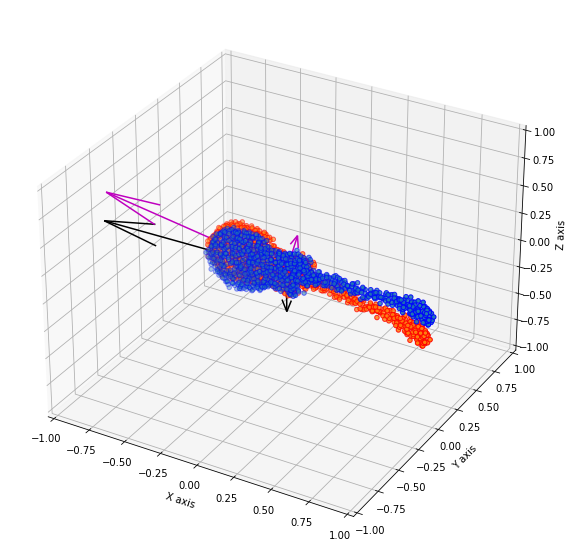

In [13]:
# from util_3d import generate_custom_pointcloud, decompose
from hypericp import torch_solve, torch_compute_components

def decompose(pointcloud):
    return pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]

pc1, pc2, _, _, _, _, euler, _ = data[351]
# print(data[351])

# f = open('debug_hyper-new.npy', 'rb')
# pc1 = np.load(f, allow_pickle=True)
# pc2 = np.load(f, allow_pickle=True)
# # rotation = np.load(f)
# euler = np.load(f, allow_pickle=True)
# debug = {
#     'rotation' : rotation,
#     'euler' : euler
# }

print(f'euler={euler}')

# print(f'{np.max(pc1)}')

if True:
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # print(f'source={pc1}')

    x1, y1, z1 = decompose(pc1.T)
    x2, y2, z2 = decompose(pc2.T)

    ax.scatter3D(x1, y1, z1, edgecolor='b')
    ax.scatter3D(x2, y2, z2, edgecolor='r')

    (U1, S1), (U2, S2) = torch_compute_components(torch.from_numpy(pc1), torch.from_numpy(pc2))
    
    print(f'X:\nU:{U1.shape}\nS={S1}')
    print(f'Y:\nU:{U2.shape}\nS={S2}')

    u1_soa = []
    for i in range(U1.shape[1]):
        u1_soa.append(np.concatenate([np.asarray([0, 0, 0]), (S1[i] / 10) * U1[:, i]]))

    u2_soa = []
    for j in range(U2.shape[1]):
        u2_soa.append(np.concatenate([np.asarray([0, 0, 0]), (S2[j] / 10) * U2[:, j]]))    


    print(f'u1_soa={u1_soa}')
    print(f'u2_soa={u2_soa}')

    def is_orth(R):
        print(f'RR={R.T @ R}')
        return np.allclose(R.T @ R, np.eye(3))

    def add_soa(soa, c):
        X, Y, Z, U, V, W = zip(*soa)
        ax.quiver(X, Y, Z, U, V, W, color=c)

    add_soa(u1_soa, 'k')
    add_soa(u2_soa, 'm')

    
R, t = torch_solve(torch.from_numpy(pc1), torch.from_numpy(pc2), verbose=True)